# Build simple agents that perform navigation on the line and the loop

Agents we want to study
<ul stlye="list-style: square">
    <li> Go inwards </li>
    <li> Simple Q-learning agent </li>
    <li> Model based agent </li>
    <li> Go up and down stereotyped </li>
    <li> Fully random decisions </li>
<ul>

In [870]:
%matplotlib inline

import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
import scipy.stats as stt
import pandas as pd
from datetime import datetime
from functools import partial
import matplotlib
import networkx as nx
import seaborn
from scipy.ndimage import gaussian_filter1d

seaborn.set(font_scale=1.5,style='ticks')

In [871]:
def get_modulo_distance(target_state,state,nStates=6):
    return np.min(np.abs([target_state-state,target_state-(state+nStates),target_state-(state-nStates)]))

In [911]:
class base_agent(object):
    """
    This is a generic class that other agents (with different policies)
    inherit from. This class implements the basic task_logic
    """
    def __init__(self,learning_params=None,task_params=None):
        """ 
        For simplicity, in the first instance, will assume that
        
        Arguments:
        =======================
        
        task_params (dict):    dictionary containing parameters that are required for running of the task
        
        learning_params (dict): parameters necessary for specifying and updating the policy
        
        """
        
        if task_params is None:
            task_params = {'len_graph':9,
                           'graph_type':'line',
                           'rew_locs_session':list(range(9)),
                           'rewards_pre_switch': 20,
                           'reward_switch_p': 0.2,
                           'choices_pre_forced': 20
                            }

        
        self.learning_params = learning_params
        self.task_params = task_params
        
        
        #helper params
        self._all_states = list(range(self.task_params['len_graph']))
        

        self._init_task_variables()
        self._init_stores()
        

        
    def _init_task_variables(self):
        #initialise variables
        self.forced = False
        self.reward_location = None
        self.current_state = None
        self.current_port = None
        self.current_reward_location = None
        self.available_states = []
        self.choices_since_reward = 0
        self.n_rewards_at_loc = 0
        self.n_reward_total = 0
        
    def _init_stores(self):
        #this is the information to extract at the end to feed into
        #the standard analysis pipeline
        self.state_seq = []
        self.rew_list = []
        self.port_seq = []
        self.forced_seq = []

    def set_available_states(self):
        """ updates available_states variables"""
        
        #if bottom edge
        if self.current_state==0:
            if self.task_params['graph_type']=='line':
                self.available_states = [1]
            else:
                self.available_states = [self.task_params['len_graph']-1,1]

        #elif top edge
        elif self.current_state==(self.task_params['len_graph']-1):

            if self.task_params['graph_type']=='line':
                self.available_states = [self.task_params['len_graph']-2]
            else:
                self.available_states = [self.task_params['len_graph']-2,0]

        #with states either side
        else:
            self.available_states = [self.current_state-1,self.current_state+1]

        #if its a forced trial
        if self.choices_since_reward>self.task_params['choices_pre_forced']:
            self.forced_seq.append(True)
            self.forced = True
            #if this is a forced trial
            if len(self.available_states)>1:
                
                if self.task_params['graph_type']=='line':
                    best_ix = np.argmin([np.abs(self.available_states[0]-self.reward_location),
                                          np.abs(self.available_states[1]-self.reward_location)])
                    self.available_states = [self.available_states[best_ix]]
                else:
                    best_ix = np.argmin([get_modulo_distance(self.reward_location,self.available_states[1]),
                                          get_modulo_distance(self.reward_location,self.available_states[1])])
                    self.available_states = [self.available_states[best_ix]]

        else:
            self.forced_seq.append(False)

    
    def init_trial(self):
        """ Initialise the task"""
        if ((self.reward_location is None) or 
            (self.n_rewards_at_loc>self.task_params['rewards_pre_switch'] and
                np.random.uniform(0,1)>self.task_params['reward_switch_p'])):
            self.update_reward_location()
        
            

        self.current_state = np.random.choice(self.poss_starting_states)
        self.set_available_states()
        #print(self.curr)
        #print(self.available_states)
        self.state_seq.append(self.current_state)
        self.port_seq.append(self.current_port)
        self.rew_list.append(False)

        
    def run(self,n_trials=3e3):
        """ Run behaviour """
        self.init_trial()
        #if self.task_params
        #print(n_trials)
        rew = False
        while self.n_reward_total<n_trials:
            if rew>0:
                self.update_policy(rew=rew,end_of_trial=True)
                self.init_trial()
                

            #print(self.available_states)
            rew = self.update_state()
            self.update_policy(rew=rew,end_of_trial=False)
            self.state_seq.append(self.current_state)
            self.port_seq.append(self.current_port)
            self.rew_list.append(rew)
                    
        
    
    def update_state(self):
        """ Received choice of 0 or 1"""
        self.do_policy()
        self.set_available_states()

        rew = False
        if self.current_state==self.reward_location:
            self.choices_since_reward = 0
            self.n_rewards_at_loc += 1
            self.choices_since_reward =0 
            self.n_reward_total += 1
            #self.rew_list.append(True)
            rew = True
        else:
            self.choices_since_reward += 1

        return rew
            
    
    def update_reward_location(self):
        self.n_rewards_at_loc = 0
        self.reward_location = np.random.choice(self.task_params['rew_locs_session'])
        self.poss_starting_states = [i for i in self.task_params['rew_locs_session'] if i!=self.reward_location]

    
    def do_policy(self):
        pass #return None
    def update_policy(self,rew,end_of_trial=False):
        """ 
        Use this function when the behavioural policy is actually updated 
        (e.g. Q-learning),not if the behavioural policy involves inference.
        use end_of_trial signal for episodic updates
        """
        pass

In [912]:
class diffusion_agent(base_agent):
    """ This agent simply makes random choices at each time point"""
    def __init__(self,learning_params=None,task_params=None):
        super().__init__(learning_params,task_params)
    
    def do_policy(self):
        self.current_state = np.random.choice(self.available_states)


In [913]:
class towards_middle_agent(base_agent):
    """ This is an agent where you have two policies. It selects between these
        two policies based on how many states are in each direction. Right now
        this is the simplest possible implementation that samples a direction and 
        sticks with it. You could imagine one where you essentially calculate values based on 
        number of states available and then make a direction decision at each point. 
        Additionally, you can just add stochasticity at all points (i.e. go in direction and change direction)
    """
    def __init__(self,learning_params=None,task_params=None):
        super().__init__(learning_params,task_params)
        
    
    def do_policy(self):
        if self.task_params['graph_type']=='line':
            
            if self.choices_since_reward==0:
                self.direction = int(np.abs(self.current_state-9)>np.abs(self.current_state-0)) #
                if len(self.available_states)==2:
                    self.current_state = self.available_states[self.direction]
                else:
                    self.current_state = self.available_states[0]
                #    self.direction = 1
                #else:
                #    self.direction = -1
            else:
                if len(self.available_states)==2:
                    self.current_state = self.available_states[self.direction]
                else:
                    if not self.forced:
                        if self.current_state==0: self.direction = 1
                        elif self.current_state==(self.task_params['len_graph']-1): self.direction = 0
                            
                    self.current_state = self.available_states[0]
        else:
            raise Exception('No idea what could happen on the loop here')
            #self.current_state = np.random.choice(self.available_states)

In [1103]:
class Qlearner(base_agent):
    """ Single-step Q-learning agent"""
    def __init__(self,learning_params=None,task_params=None):
        super().__init__(learning_params,task_params)
        self.sigmoid = lambda x: 1/(1+np.exp(-(x[1]-x[0])))
        self.decs = []
        self.Q_values = np.zeros([self.task_params['len_graph'],2])
        self.G = 0.99
        self.alpha = .7
        self.cost = .1
        self.rVal = 10
        self.prev_state = None
        self.up = None
        
    def do_policy(self):
        self.prev_state = self.current_state + 0
        if len(self.available_states)==2:
            p_ = self.sigmoid(self.Q_values[self.current_state])
            choice = np.random.choice([0,1],p=[1-p_,p_])
            self.current_state = self.available_states[choice]
        else:
            choice = self.current_state==0
            self.current_state = self.available_states[0]
        self.up = choice
        #self.decs.append([self.prev_state,choice,(self.current_state==self.reward_location)-self.cost])
        #print(prev_state,self.current_state)
    def update_policy(self,rew=False,end_of_trial=False):
        """ update Q-values """
        #if end_of_trial:
            #gammas = [self.G**i for i in reversed(range(len(self.decs)))]
        Q_new = self.Q_values.copy()

        if end_of_trial:
            nextS_term = 0
            nextS_term = np.max(self.Q_values[self.current_state])
        else:
            nextS_term = np.max(self.Q_values[self.current_state])
        Q_new[self.prev_state,self.up] = self.Q_values[self.prev_state,self.up] + self.alpha*((rew)*self.rVal -self.cost + self.G*nextS_term - self.Q_values[self.prev_state,self.up])
        self.decs = []
        self.Q_values = Q_new.copy()

In [1112]:
class Model_based_agent(base_agent):
    """ This is a perfect model based agent. Exploration policy right now is just
        random walk. Another thing to consider here is what happens on the loop when
        both directions are equal. Right now it just chooses direction 0, could make
        this stochastic or do something else."""
    def __init__(self,learning_params=None,task_params=None):
        super().__init__()
        
        self.known_reward_location = False
    
    def exploration_policy(self):
        """ explore the environment randomly"""
        self.current_state = np.random.choice(self.available_states)

    def do_policy(self):
        if not self.known_reward_location:
            self.exploration_policy()
        else:
            
            if len(self.available_states)==2:

                if self.task_params['graph_type']=='line':

                    d0 = np.abs(self.known_reward_location-self.available_states[0])
                    d1 = np.abs(self.known_reward_location-self.available_states[1])
                else:
                    d0 = get_modulo_distance(self.known_reward_location,
                                            self.available_states[0],
                                            nStates=self.task_params['len_graph'])
                    d1 = get_modulo_distance(self.known_reward_location,
                                            self.available_states[1],
                                            nStates=self.task_params['len_graph'])
                    
                self.current_state = self.available_states[np.argmin([d0,d1])]

            else:
                self.current_state = self.available_states[0]
                
    def update_policy(self,end_of_trial,rew):
        #print(1)
        if end_of_trial:
            if self.known_reward_location is None:
                self.known_reward_location = self.current_state
        #else:
            elif (self.current_state!=self.known_reward_location):
                self.known_reward_location = self.current_state
        else:
            if (self.current_state==self.known_reward_location):
                self.known_reward_location = None
                
            
        


In [1105]:
#replace this with behavioural model of your choice
aa = Qlearner()
#aa.task_params['graph_type'] = 'loop'
aa.task_params['rewards_pre_switch'] = 50
aa.run(n_trials=100)

In [1106]:
aa.reward_location

1

In [1107]:
#aa.Q_values[1:-1]
aa.Q_values[0] = [0,10]; aa.Q_values[-1] = [10,0]
aa.Q_values[aa.reward_location] = np.nan
aa.Q_values


array([[ 0.        , 10.        ],
       [        nan,         nan],
       [18.54632789,  4.73109716],
       [18.26086435,  1.74539377],
       [17.97822971,  1.54033119],
       [17.69545246,  1.49206835],
       [17.24597802,  3.21119432],
       [13.39688554, -0.1       ],
       [10.        ,  0.        ]])

In [1108]:
for i in aa.Q_values:
    print(aa.sigmoid(i))

0.9999546021312976
nan
1.0002788742671351e-06
6.720819498848021e-08
7.262921500311995e-08
9.182472872673538e-08
8.031016802099068e-07
1.375233649347636e-06
4.5397868702434395e-05


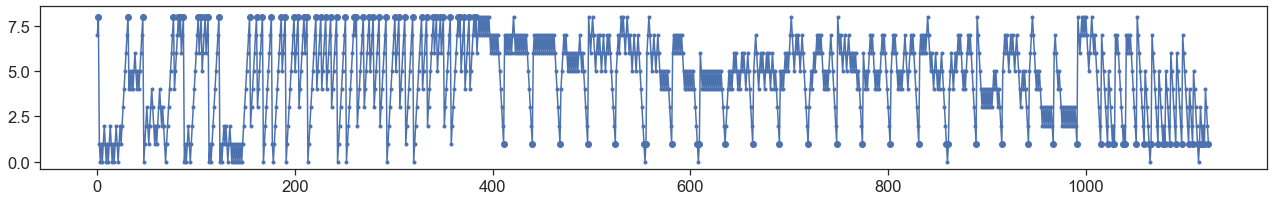

In [1109]:
plt.figure(figsize=(22,3))
plt.plot(aa.state_seq,marker='.')
plt.scatter(np.where(aa.rew_list)[0],np.array(aa.state_seq)[np.where(aa.rew_list)[0]])
#plt.xlim(1200,1450)

In [529]:
class Model_based_agent(base_agent):
    """ This is a perfect model based agent. Exploration policy right now is just
        random walk. Another thing to consider here is what happens on the loop when
        both directions are equal. Right now it just chooses direction 0, could make
        this stochastic or do something else."""
    def __init__(self,learning_params=None,task_params=None):
        super().__init__()
        
        self.known_reward_location = False
    
    def exploration_policy(self):
        """ explore the environment randomly"""
        self.current_state = np.random.choice(self.available_states)

    def do_policy(self):
        if not self.known_reward_location:
            self.exploration_policy()
        else:
            
            if len(self.available_states)==2:

                if self.task_params['graph_type']=='line':

                    d0 = np.abs(self.known_reward_location-self.available_states[0])
                    d1 = np.abs(self.known_reward_location-self.available_states[1])
                else:
                    d0 = get_modulo_distance(self.known_reward_location,
                                            self.available_states[0],
                                            nStates=self.task_params['len_graph'])
                    d1 = get_modulo_distance(self.known_reward_location,
                                            self.available_states[1],
                                            nStates=self.task_params['len_graph'])
                    
                self.current_state = self.available_states[np.argmin([d0,d1])]

            else:
                self.current_state = self.available_states[0]
                
    def update_policy(self,end_of_trial,rew):
        #print(1)
        if end_of_trial:
            if self.known_reward_location is None:
                self.known_reward_location = self.current_state
        #else:
            elif (self.current_state!=self.known_reward_location):
                self.known_reward_location = self.current_state
        else:
            if (self.current_state==self.known_reward_location):
                self.known_reward_location = None
                
            
        


In [530]:
aa.current_state

7

In [531]:
aa.available_states

[6, 8]

In [532]:
aa.set_available_states()

In [533]:
aa.reward_location

7

In [1110]:
aa = Model_based_agent()
aa.task_params['graph_type'] = 'loop'

aa.run(n_trials=50)

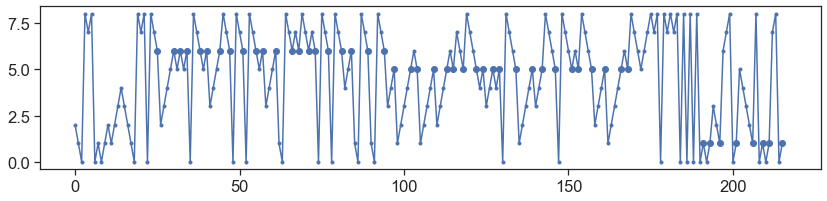

In [1111]:
plt.figure(figsize=(14,3))
plt.plot(aa.state_seq,marker='.')
plt.scatter(np.where(aa.rew_list)[0],np.array(aa.state_seq)[np.where(aa.rew_list)[0]])

In [488]:
len(aa.forced_seq)

109

In [385]:
cst = 1
[np.abs(cst-0),np.abs(cst-9)]

[1, 8]

In [19]:
class Qlearner(base_agent):
    
    def __init__(self,learning_params,task_params):
        pass

In [20]:
class Model_based_agent(base_agent):
    
    def __init__(self,learning_params,task_params):
        pass